# Script to prepare data for YOLO training for the 1 class problem

In [54]:
from IPython.display import Image  # for displaying images
import os 
import random
import shutil
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import librosa
import librosa.display

In [55]:
# Get csv paths
path_csv_train = "../../Dataset acoustique insectes/CSVs morceaux audio 5s/Audible/train_audible_recording_chunks.csv"
path_csv_test = "../../Dataset acoustique insectes/CSVs morceaux audio 5s/Audible/test_audible_recording_chunks.csv"
path_csv_val = "../../Dataset acoustique insectes/CSVs morceaux audio 5s/Audible/val_audible_recording_chunks.csv"

# Get spectrograms paths
path_spectro_train = "../../Dataset acoustique insectes/Selection morceaux audio 5s/Audible/train_spectro"
path_spectro_test = "../../Dataset acoustique insectes/Selection morceaux audio 5s/Audible/test_spectro"
path_spectro_val = "../../Dataset acoustique insectes/Selection morceaux audio 5s/Audible/val_spectro"

path_spectro = [path_spectro_train, path_spectro_test, path_spectro_val]

# Using pandas to read the CSV file into a DataFrame
df_train = pd.read_csv(path_csv_train)
df_test = pd.read_csv(path_csv_test)
df_val = pd.read_csv(path_csv_val)

In [56]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(df_train['label'])

def get_data_info(df):
    y = df['label']
    y_category = df['label_category']
    y_kingdom = df['label_kingdom']
    y_class = df['label_class']
    y_order = df['label_order']
    y_family = df['label_family']
    y_subfamily = df['label_subfamily']

    # Convertir les étiquettes en nombres
    y_encoded = label_encoder.transform(y)
    
    # create new empty dataframe
    new_df = pd.DataFrame()

    new_df['label'] = y_encoded
    new_df['t1'] = df["annotation_initial_time"] - df["chunk_initial_time"]
    new_df['t2'] = df["annotation_final_time"] - df["chunk_initial_time"]
    new_df['f1'] = df['min_frequency'].astype(int)
    new_df['f2'] = df['max_frequency'].astype(int)
    code_unique = df['code_unique'] 
    str_to_add = '_split_' + df['chunk_initial_time'].astype(str) + '_' + df['chunk_final_time'].astype(str)
    new_df['filename'] = code_unique + str_to_add + '.png'
    new_df['sr'] = df['sampling_rate']
    new_df['duration_chunk'] = df['chunk_final_time'] - df['chunk_initial_time']
    new_df['label_class'] = y_class

    # Gestion des valeurs manquantes
    new_df = new_df.dropna()

    return new_df

info_train = get_data_info(df_train)
info_test = get_data_info(df_test)
info_val = get_data_info(df_val)

infos_data = [info_train, info_test, info_val]

In [57]:
info_train

,label,t1,t2,f1,f2,filename,sr,duration_chunk,label_class
1,22,0.000000,5.000000,3248,4453,Anura_XXXXigeXXES_01VII2022_330_split_0_5.png,44100,5,Insecta
2,22,0.000000,5.000000,3248,4453,Anura_XXXXigeXXES_01VII2022_330_split_5_10.png,44100,5,Insecta
4,22,0.000000,5.000000,3248,4453,Anura_XXXXigeXXES_01VII2022_330_split_10_15.png,44100,5,Insecta
5,60,0.000000,5.000000,7918,11211,Anura_XXXXigeXXES_01VII2022_335_split_0_5.png,44100,5,Insecta
6,60,0.000000,5.000000,7918,11211,Anura_XXXXigeXXES_01VII2022_335_split_5_10.png,44100,5,Insecta
...,...,...,...,...,...,...,...,...,...
10784,9,2.296621,3.300916,5007,16160,Aves_KrDe_AwSw00PL_16VII2014_4613_split_175_18...,44100,5,Insecta
10785,9,4.691478,5.000000,4750,16553,Aves_KrDe_AwSw00PL_16VII2014_4613_split_175_18...,44100,5,Insecta
10786,9,0.000000,0.674299,5416,17367,Aves_KrDe_AwSw00PL_16VII2014_4613_split_175_18...,44100,5,Insecta
10787,9,3.399642,3.863163,5007,15776,Aves_KrDe_AwSw00PL_16VII2014_4613_split_180_18...,44100,5,Insecta


In [58]:
# remove labels with sr == 384000
info_train = info_train[info_train['sr'] != 384000]
info_test = info_test[info_test['sr'] != 384000]
info_val = info_val[info_val['sr'] != 384000]

# Keep only if label_class is Insecta
info_train = info_train[info_train['label_class'] == 'Insecta']
info_test = info_test[info_test['label_class'] == 'Insecta']
info_val = info_val[info_val['label_class'] == 'Insecta']

# correct the ids
info_train = info_train.reset_index(drop=True)
info_test = info_test.reset_index(drop=True)
info_val = info_val.reset_index(drop=True)

infos_data = [info_train, info_test, info_val]

info_train

,label,t1,t2,f1,f2,filename,sr,duration_chunk,label_class
0,22,0.000000,5.000000,3248,4453,Anura_XXXXigeXXES_01VII2022_330_split_0_5.png,44100,5,Insecta
1,22,0.000000,5.000000,3248,4453,Anura_XXXXigeXXES_01VII2022_330_split_5_10.png,44100,5,Insecta
2,22,0.000000,5.000000,3248,4453,Anura_XXXXigeXXES_01VII2022_330_split_10_15.png,44100,5,Insecta
3,60,0.000000,5.000000,7918,11211,Anura_XXXXigeXXES_01VII2022_335_split_0_5.png,44100,5,Insecta
4,60,0.000000,5.000000,7918,11211,Anura_XXXXigeXXES_01VII2022_335_split_5_10.png,44100,5,Insecta
...,...,...,...,...,...,...,...,...,...
6036,9,2.296621,3.300916,5007,16160,Aves_KrDe_AwSw00PL_16VII2014_4613_split_175_18...,44100,5,Insecta
6037,9,4.691478,5.000000,4750,16553,Aves_KrDe_AwSw00PL_16VII2014_4613_split_175_18...,44100,5,Insecta
6038,9,0.000000,0.674299,5416,17367,Aves_KrDe_AwSw00PL_16VII2014_4613_split_175_18...,44100,5,Insecta
6039,9,3.399642,3.863163,5007,15776,Aves_KrDe_AwSw00PL_16VII2014_4613_split_180_18...,44100,5,Insecta


In [59]:
# print when f2 > 24000
info_train[info_train['f1'] > 24000]

,label,t1,t2,f1,f2,filename,sr,duration_chunk,label_class


In [60]:
# prepare the data for the yolo dataset

# path to save the images and labels
path_yolo_dataset = "../../Dataset acoustique insectes/Selection morceaux audio 5s/Audible/Yolo_1_class"

# create the directory if it does not exist
if not os.path.exists(path_yolo_dataset):
    os.makedirs(path_yolo_dataset)

# create the subdirectories if they do not exist
os.makedirs(os.path.join(path_yolo_dataset, 'images'), exist_ok=True)
os.makedirs(os.path.join(path_yolo_dataset, 'labels'), exist_ok=True)

# Path to the destination images and labels
path_dest_images_train = os.path.join(path_yolo_dataset, 'images', 'train')
path_dest_labels_train = os.path.join(path_yolo_dataset, 'labels', 'train')
path_dest_images_test = os.path.join(path_yolo_dataset, 'images', 'test')
path_dest_labels_test = os.path.join(path_yolo_dataset, 'labels', 'test')
path_dest_images_val = os.path.join(path_yolo_dataset, 'images', 'val')
path_dest_labels_val = os.path.join(path_yolo_dataset, 'labels', 'val')

path_dest_images = [path_dest_images_train, path_dest_images_test, path_dest_images_val]
path_dest_labels = [path_dest_labels_train, path_dest_labels_test, path_dest_labels_val]

# Create the destination directories
for d in path_dest_images:
    os.makedirs(d, exist_ok=True)
for d in path_dest_labels:
    os.makedirs(d, exist_ok=True)

In [61]:
# add the images to the images directory

# Loop for train, test and val
for i in range(len(path_dest_images)):
    # List all files in the source directory
    files = os.listdir(path_spectro[i])

    # Copy images to the destination directory
    for file in files:
        if file.endswith('.png') and file in list(infos_data[i]['filename']):
            source_path = os.path.join(path_spectro[i], file)
            dest_path = os.path.join(path_dest_images[i], file)
            shutil.copy(source_path, dest_path)

In [62]:
# add labels to the label directory

# Loop for train, test and val
for i in range(len(path_dest_labels)):
    info_data = infos_data[i]
    for elt in tqdm(info_data.iterrows()):
        # get the row values
        index, row = elt
        filename = row['filename']
        t1 = row['t1']
        t2 = row['t2']
        f1 = row['f1']
        f2 = min(24000, row['f2'])
        label_class = row['label_class']
        chunk_duration = row['duration_chunk']
        
        # Get the image dimensions
        img = Image.open(os.path.join(path_spectro[i], filename))
        img_width, img_height = img.size
        
        # convert values to pixels
        t1_pixel = int(t1 * img_width/chunk_duration)
        t2_pixel = int(t2 * img_width/chunk_duration)
        f2_pixel = img_height - int(f1 * img_height/(48000/2))
        f1_pixel = img_height - int(f2 * img_height/(48000/2))
    
        # Normalize the coordinates
        t1_norm = t1_pixel/img_width
        t2_norm = t2_pixel/img_width
        f1_norm = f1_pixel/img_height
        f2_norm = f2_pixel/img_height
        
        # format : label x_center y_center width height
        x_center = (t1_norm + t2_norm)/2
        y_center = (f1_norm + f2_norm)/2
        width = t2_norm - t1_norm
        height = f2_norm - f1_norm
        
        # Create the label file
        label_file = filename.replace('.png', '.txt')
        
        # Check if the label file already exists
        if os.path.exists(os.path.join(path_dest_labels[i], label_file)):
            # Read the content of the file
            with open(os.path.join(path_dest_labels[i], label_file), 'r') as file:
                content = file.read()
                # Check if the bounding box already exists in the content
                if f"0 {x_center} {y_center} {width} {height}\n" not in content:
                    # If it doesn't exist, open the file in append mode and write the new bounding box
                    with open(os.path.join(path_dest_labels[i], label_file), 'a') as file:
                        if label_class == "Insecta":
                            file.write(f"0 {x_center} {y_center} {width} {height}\n")
        else:
            with open(os.path.join(path_dest_labels[i], label_file), 'w') as file:
                if label_class == "Insecta":
                    file.write(f"0 {x_center} {y_center} {width} {height}\n")

6041it [00:08, 696.84it/s]
767it [00:01, 677.64it/s]
779it [00:01, 619.64it/s]


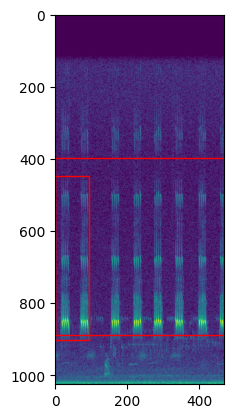

44100


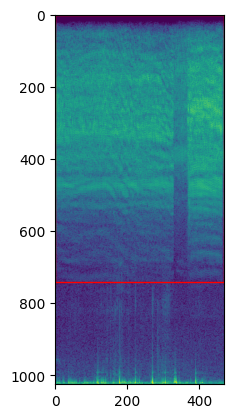

96000


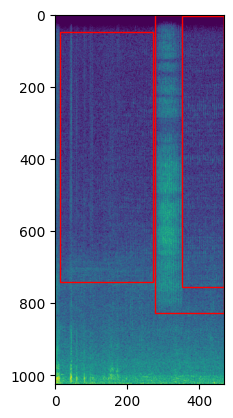

96000


In [66]:
def draw_bounding_boxes(img_path, label_file):
    # Open the image
    img = Image.open(img_path)
    draw = ImageDraw.Draw(img)

    # Read the label file
    with open(label_file, 'r') as file:
        lines = file.readlines()
        plt.imshow(img)
        for line in lines:
            label, x_center, y_center, width, height = map(float, line.split())
            img_width, img_height = img.size
            x_center *= img_width
            y_center *= img_height
            width *= img_width
            height *= img_height

            x1 = int(x_center - width/2)
            x2 = int(x_center + width/2)
            y1 = int(y_center - height/2)
            y2 = int(y_center + height/2)

            # Create a Rectangle patch
            rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor='r', facecolor='none')
            plt.gca().add_patch(rect)
            
    # Display the image with bounding boxes
    plt.show()

# train check
# get random id
id = random.randint(0, len(info_train))
img_path = os.path.join(path_dest_images_train, info_train.iloc[id]['filename'])
label_file = os.path.join(path_dest_labels_train, info_train.iloc[id]['filename'].replace('.png', '.txt'))
draw_bounding_boxes(img_path, label_file)
print(info_train.iloc[id]['sr'])

# test check
# get random id
id = random.randint(0, len(info_test))
img_path = os.path.join(path_dest_images_test, info_test.iloc[id]['filename'])
label_file = os.path.join(path_dest_labels_test, info_test.iloc[id]['filename'].replace('.png', '.txt'))
draw_bounding_boxes(img_path, label_file)
print(info_test.iloc[id]['sr'])

# val check
# get random id
id = random.randint(0, len(info_val))
img_path = os.path.join(path_dest_images_val, info_val.iloc[id]['filename'])
label_file = os.path.join(path_dest_labels_val, info_val.iloc[id]['filename'].replace('.png', '.txt'))
draw_bounding_boxes(img_path, label_file)
print(info_val.iloc[id]['sr'])

In [64]:
# Assuming labels is a list obtained from label_encoder.classes_
labels = ['Insecta']

data_yaml = f"path: {'../' + path_yolo_dataset}\n" \
            f"train: {'images/train'}\n" \
            f"test: {'images/test'}\n" \
            f"val: {'images/val'}\n" \
            f"nc: {len(labels)}\n" \
            f"names:\n" \
            + "\n".join([f"  {index}: {label}" for index, label in enumerate(labels)]) + "\n"

# Create the yaml file
with open(os.path.join(path_yolo_dataset, 'data.yaml'), 'w') as file:
    file.write(data_yaml)

In [65]:
# test the data.yaml file
with open(os.path.join(path_yolo_dataset, 'data.yaml'), 'r') as file:
    print(file.read())

path: ../../../Dataset acoustique insectes/Selection morceaux audio 5s/Audible/Yolo_1_class
train: images/train
test: images/test
val: images/val
nc: 1
names:
  0: Insecta

